### Recommend to export in HTML file by monthly or optimization round

In [0]:
import pandas as pd
import numpy as np
from math import pi
from datetime import datetime, timedelta, time
from dateutil.relativedelta import *
from calendar import monthrange
from functools import reduce
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql import *
from pyspark.sql.types import *

import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
client = "ABC"
user_nm = "pakthewee_ran"
current_month = datetime.now().strftime("%Y%m")
month_l1 = (datetime.now() - timedelta(days=30)).strftime("%Y%m")
month_l2 = (datetime.now() - timedelta(days=60)).strftime("%Y%m")
path_master = f"gs://aaa/bbb/ccc"
print(path_master)

print("current month: ", current_month)
print("last 1 month: ", month_l1)
print("last 2 month: ", month_l2)

gs://tdg-ds-campaign/adpulse/AIA/user/pakthewee_ran/website_clustering_analysis
current month:  202505
last 1 month:  202504
last 2 month:  202503


In [0]:
def save_csv(path, df):
    df.coalesce(1).write.mode("overwrite").format("csv").option("header", True).save(path)


def change_csv_name(path):
    files = dbutils.fs.ls(path)
    csv_file = [x.path for x in files if x.path.endswith(".csv")][0]
    print(csv_file)

    dbutils.fs.cp(csv_file, path.rstrip('/') + ".csv")
    dbutils.fs.rm(path, True)
    print(path.rstrip('/') + ".csv")    


def get_website_segmentation(month):
    path = f"{path_master}/website_segmentation"
    df = spark.read.format("delta").load(path)
    df = df.filter(col("par_month") == month)
    return df


def get_performance_ntile(df, metric):
    print("Validate by: ", metric)
    df = df.groupBy(col(f"{metric}_ntile"))\
           .agg(
               min(col(f"{metric}")).alias("min"),
               max(col(f"{metric}")).alias("max"),
               avg(col(f"{metric}")).alias("avg"),
               variance(col(f"{metric}")).alias("var")
           )
    # Correctly use the column name in sort without converting it to int
    df = df.withColumn("ntile_num", col(f"{metric}_ntile").cast("int"))
    df = df.drop(col(f"{metric}_ntile"))
    df = df.select("ntile_num", "min", "max", "avg", "var")
    df = df.sort(col("ntile_num").asc())
    return df


def get_avg_var(df):
    print("performance by avg/var")
    df = df.agg(
            avg("filledform_all_prod").alias("avg_ff"),
            variance("filledform_all_prod").alias("var_ff"),
            avg("ctr_all_prod").alias("avg_ctr"),
            variance("ctr_all_prod").alias("var_ctr"),
            avg("cvr_all_prod").alias("avg_cvr"),
            variance("cvr_all_prod").alias("var_cvr"),
            avg("lead10k_all_prod").alias("avg_lead10k"),
            variance("lead10k_all_prod").alias("var_lead10k")
            )
    return df


def get_avg_min_max_by_group(df, group):
    print("performance by avg/min/max by group")
    df = df.groupBy(group).agg(
            count("domainname").alias("count"),
            avg("filledform_all_prod").alias("avg_ff"),
            min("filledform_all_prod").alias("min_ff"),
            max("filledform_all_prod").alias("max_ff"),
            avg("ctr_all_prod").alias("avg_ctr"),
            min("ctr_all_prod").alias("min_ctr"),
            max("ctr_all_prod").alias("max_ctr"),
            avg("cvr_all_prod").alias("avg_cvr"),
            min("cvr_all_prod").alias("min_cvr"),
            max("cvr_all_prod").alias("max_cvr"),
            avg("lead10k_all_prod").alias("avg_lead10k"),
            min("lead10k_all_prod").alias("min_lead10k"),
            max("lead10k_all_prod").alias("max_lead10k"),
            avg("tps").alias("avg_tps"),
            min("tps").alias("min_tps"),
            max("tps").alias("max_tps")          
        )
    return df

In [0]:
df_ws = get_website_segmentation(month_l1)
df_ws.limit(5).display()
df_ws.printSchema()

risk_group,domainname,segment,sent_all_prod,clicked_all_prod,filledform_all_prod,ctr_all_prod,cvr_all_prod,lead10k_all_prod,tps,filledform_all_prod_ntile,ctr_all_prod_ntile,cvr_all_prod_ntile,lead10k_all_prod_ntile,tps_ntile,par_month
3.low,musicradio.com,entertainment,2304,11,1,0.004774305555555556,0.09090909090909091,4.340277777777778,0.040155092592592596,1,6,10,9,1,202504
3.low,ultimate-guitar.com,entertainment,23436,102,1,0.004352278545826933,0.00980392156862745,0.4266939750810719,0.040741512345679014,1,4,1,1,1,202504
3.low,aviasales.ru,travel,3814,23,1,0.006030414263240692,0.043478260869565216,2.6219192448872577,0.0436141975308642,1,9,4,6,1,202504
3.low,peopleplus.co.th,estate,8815,39,1,0.004424276800907544,0.02564102564102564,1.1344299489506524,0.046933641975308645,1,5,2,1,1,202504
3.low,myreadingmanga.info,entertainment,20187,59,1,0.002922673007380988,0.01694915254237288,0.4953683063357606,0.048942129629629634,1,1,1,1,1,202504


root
 |-- risk_group: string (nullable = true)
 |-- domainname: string (nullable = true)
 |-- segment: string (nullable = true)
 |-- sent_all_prod: long (nullable = true)
 |-- clicked_all_prod: long (nullable = true)
 |-- filledform_all_prod: long (nullable = true)
 |-- ctr_all_prod: double (nullable = true)
 |-- cvr_all_prod: double (nullable = true)
 |-- lead10k_all_prod: double (nullable = true)
 |-- tps: double (nullable = true)
 |-- filledform_all_prod_ntile: integer (nullable = true)
 |-- ctr_all_prod_ntile: integer (nullable = true)
 |-- cvr_all_prod_ntile: integer (nullable = true)
 |-- lead10k_all_prod_ntile: integer (nullable = true)
 |-- tps_ntile: integer (nullable = true)
 |-- par_month: integer (nullable = true)



In [0]:
print("Part1: Statical performance")
pd_ws = df_ws.toPandas()
pd_stat = pd_ws.describe()
sp_stat = spark.createDataFrame(pd_stat)
sp_stat.display()
print("\n")

print("Part2: Performance by metrics")
df_ff = get_performance_ntile(df_ws, "filledform_all_prod")
df_ff.display()
print("\n")

df_ctr = get_performance_ntile(df_ws, "ctr_all_prod")
df_ctr.display()
print("\n")

df_cvr = get_performance_ntile(df_ws, "cvr_all_prod")
df_cvr.display()
print("\n")

df_lead10k = get_performance_ntile(df_ws, "lead10k_all_prod")
df_lead10k.display()
print("\n")

df_tps = get_performance_ntile(df_ws, "tps")
df_tps.display()
print("\n")

print("Part 3: Performance by avg/var")
df_avg_var = get_avg_var(df_ws)
df_avg_var.display()
print("\n")

print("Part 4: Performance by avg/min/max by group")
df_avg_min_max = get_avg_min_max_by_group(df_ws, "risk_group")
df_avg_min_max.display()
print("\n")

Part1: Statical performance


sent_all_prod,clicked_all_prod,filledform_all_prod,ctr_all_prod,cvr_all_prod,lead10k_all_prod,tps,filledform_all_prod_ntile,ctr_all_prod_ntile,cvr_all_prod_ntile,lead10k_all_prod_ntile,tps_ntile,par_month
563.0,563.0,563.0,563.0,563.0,563.0,563.0,563.0,563.0,563.0,563.0,563.0,563.0
663216.7975133215,2973.4191829484903,154.73712255772648,0.005084064903958065,0.05536292038380241,2.640874690483503,3.1768263340679344,5.481349911190053,5.481349911190053,5.481349911190053,5.481349911190053,5.481349911190053,202504.0
1675523.7253835404,7320.644685682306,365.4120306240638,0.003079003232031106,0.025531572386514413,1.3767829088506747,8.295888654309689,2.879104427180647,2.879104427180647,2.879104427180647,2.879104427180647,2.879104427180647,0.0
2119.0,11.0,1.0,0.0015806498114600905,0.004490597810833568,0.3000570108320581,0.04003780864197531,1.0,1.0,1.0,1.0,1.0,202504.0
40528.5,186.5,8.0,0.004047936202802492,0.03828769215107401,1.702109632487963,0.09362808641975308,3.0,3.0,3.0,3.0,3.0,202504.0
115013.0,566.0,28.0,0.004652275044067562,0.0528391167192429,2.4038370262754283,0.2452831790123457,5.0,5.0,5.0,5.0,5.0,202504.0
426387.0,2071.0,115.0,0.0054493387064269,0.06863649077702211,3.2093936553300964,1.2636770833333333,8.0,8.0,8.0,8.0,8.0,202504.0
1.5239159E7,62677.0,3190.0,0.050958966804445144,0.14893617021276595,9.70988439988978,54.90982793209877,10.0,10.0,10.0,10.0,10.0,202504.0




Part2: Performance by metrics
Validate by:  filledform_all_prod


ntile_num,min,max,avg,var
1,1,3,1.6666666666666667,0.5476190476190477
2,3,7,4.894736842105263,1.0958646616541359
3,7,11,8.578947368421053,1.4624060150375957
4,11,18,13.928571428571429,4.467532467532475
5,18,29,23.125,11.529545454545467
6,29,48,37.32142857142857,23.78571428571427
7,48,76,60.410714285714285,74.24642857142851
8,79,163,115.78571428571429,616.4987012987012
9,165,386,248.64285714285714,3833.8337662337676
10,391,3190,1041.0357142857142,418882.65324675344




Validate by:  ctr_all_prod


ntile_num,min,max,avg,var
1,0.0015806498114600905,0.003451995685005394,0.002947774074791358,1.941255958691368E-7
2,0.0034633682207421503,0.003918218025564574,0.0037211819190979436,1.585773565351478E-8
3,0.003920759389186958,0.004181361927807388,0.00406174763218983,6.030480444747299E-9
4,0.004184365822252199,0.004412281413011162,0.0042979399277188165,5.407742707034805E-9
5,0.004412485700277823,0.004653613135481605,0.004532075697219908,5.0973948810024616E-9
6,0.004657765159916604,0.004915142618025162,0.0047740879199901585,4.501014693757457E-9
7,0.004915472252848218,0.005225139544625975,0.0050619608752955365,1.0214742747039219E-8
8,0.005227069462386962,0.005639326343731654,0.005458690857546327,1.3104790977371836E-8
9,0.0056478489836415905,0.00632647485945161,0.005904433005616512,3.3885190453929995E-8
10,0.006331395610833221,0.050958966804445144,0.010161498042360597,6.072606570897578E-5




Validate by:  cvr_all_prod


ntile_num,min,max,avg,var
1,0.004490597810833568,0.024691358024691357,0.016865813356090237,3.482214195647215E-5
2,0.02515128593040847,0.03389830508474576,0.02966558194917078,6.373811971775457E-6
3,0.03418803418803419,0.041666666666666664,0.03820663207493278,4.8966510289524876E-6
4,0.04177545691906005,0.04697986577181208,0.044372547549419016,2.3095194358342427E-6
5,0.047396386822529224,0.052845528455284556,0.050679809642649884,2.6721372157763305E-6
6,0.05293048614266243,0.05934718100890208,0.05639796030358829,3.926348488260441E-6
7,0.05939226519337017,0.06504065040650407,0.061713090982666995,2.958634645486802E-6
8,0.06506024096385542,0.07272727272727272,0.06889567529796893,4.799104867493544E-6
9,0.07289293849658314,0.09059233449477352,0.08086260323272529,3.0463384791457557E-5
10,0.09063670411985018,0.14893617021276595,0.10742218112329796,2.460225393629008E-4




Validate by:  lead10k_all_prod


ntile_num,min,max,avg,var
1,0.3000570108320581,1.189202045427518,0.8919681021136536,0.05472222799438263
2,1.194943001218842,1.5918727659512886,1.4022277763265927,0.017701813539077235
3,1.5926102882624622,1.8205067077003099,1.7023386877070252,0.003687785831200429
4,1.8381870223996217,2.1467184481177184,1.9991618710118317,0.009644041312206643
5,2.1616882526884384,2.404981236807469,2.2929175197622564,0.005033511256436007
6,2.4124254099349356,2.6864268284492603,2.547211400676282,0.0067626901458414275
7,2.6873652639404617,3.046365685736916,2.8525358488717183,0.011990277360683399
8,3.0487700439502468,3.4489894460922947,3.2153087846473913,0.012582175942534728
9,3.4494653328734044,4.368761456127189,3.9141573946529356,0.0789580956116481
10,4.37636761487965,9.70988439988978,5.661028260231475,1.6226238410062266




Validate by:  tps


ntile_num,min,max,avg,var
1,0.04003780864197531,0.052168209876543206,0.045813095624864644,1.4854276534839427E-5
2,0.052570216049382716,0.0768449074074074,0.06316955003248863,4.228346169869262E-5
3,0.07688194444444445,0.11104861111111111,0.0938193226120858,1.0911575528040498E-4
4,0.1112854938271605,0.1552530864197531,0.13438935736331567,1.6049410682785018E-4
5,0.15546759259259257,0.24715817901234569,0.19929654431216934,8.790596787297516E-4
6,0.2536203703703704,0.43129166666666663,0.3414528218694886,0.002941414393299175
7,0.43384876543209877,0.8366689814814815,0.588570712081129,0.012685607852973074
8,0.8527206790123457,1.9261782407407404,1.2964689429012346,0.08811400900245275
9,1.942033950617284,9.308765432098765,4.10911115244709,4.198285067478072
10,9.508109567901235,54.90982793209877,25.062737502755738,143.22737709481723




Part 3: Performance by avg/var
performance by avg/var


avg_ff,var_ff,avg_ctr,var_ctr,avg_cvr,var_cvr,avg_lead10k,var_lead10k
154.73712255772648,133525.95212480167,0.005084064903958066,9.480260902857994E-6,0.055362920383802465,6.518611885278248E-4,2.640874690483502,1.8955311781033246




Part 4: Performance by avg/min/max by group
performance by avg/min/max by group


risk_group,count,avg_ff,min_ff,max_ff,avg_ctr,min_ctr,max_ctr,avg_cvr,min_cvr,max_cvr,avg_lead10k,min_lead10k,max_lead10k,avg_tps,min_tps,max_tps
3.low,285,45.99298245614035,1,1669,0.0052613822495621194,0.0015806498114600905,0.050958966804445144,0.04463961257848403,0.004490597810833568,0.14814814814814814,2.0677041571354122,0.3000570108320581,7.68344218209758,1.7063274989170458,0.04003780864197531,48.65291049382717
2.mid,180,221.88888888888889,18,2933,0.004941474868066892,0.002303254699133379,0.013264053872908936,0.06315067995979501,0.014196355724775633,0.14893617021276595,3.0955616820911316,1.862907732841289,9.70988439988978,3.825184542181069,0.04031635802469136,54.90982793209877
1.high,98,347.64285714285717,79,3190,0.004830297179093341,0.003091443420784367,0.006928361291937907,0.07224400202499692,0.04561751468456785,0.12518195050946143,3.472608807981798,2.433264723246055,7.6470138410950526,6.262415013227514,0.11546682098765433,47.527835648148155


In [0]:
pd_ws.describe()

,sent_all_prod,clicked_all_prod,filledform_all_prod,ctr_all_prod,cvr_all_prod,lead10k_all_prod,tps,filledform_all_prod_ntile,ctr_all_prod_ntile,cvr_all_prod_ntile,lead10k_all_prod_ntile,tps_ntile,par_month
count,5.630000e+02,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.0
mean,6.632168e+05,2973.419183,154.737123,0.005084,0.055363,2.640875,3.176826,5.481350,5.481350,5.481350,5.481350,5.481350,202504.0
std,1.675524e+06,7320.644686,365.412031,0.003079,0.025532,1.376783,8.295889,2.879104,2.879104,2.879104,2.879104,2.879104,0.0
min,2.119000e+03,11.000000,1.000000,0.001581,0.004491,0.300057,0.040038,1.000000,1.000000,1.000000,1.000000,1.000000,202504.0
25%,4.052850e+04,186.500000,8.000000,0.004048,0.038288,1.702110,0.093628,3.000000,3.000000,3.000000,3.000000,3.000000,202504.0
50%,1.150130e+05,566.000000,28.000000,0.004652,0.052839,2.403837,0.245283,5.000000,5.000000,5.000000,5.000000,5.000000,202504.0
75%,4.263870e+05,2071.000000,115.000000,0.005449,0.068636,3.209394,1.263677,8.000000,8.000000,8.000000,8.000000,8.000000,202504.0
max,1.523916e+07,62677.000000,3190.000000,0.050959,0.148936,9.709884,54.909828,10.000000,10.000000,10.000000,10.000000,10.000000,202504.0


###Visualization

In [0]:
df_pd = pd_ws

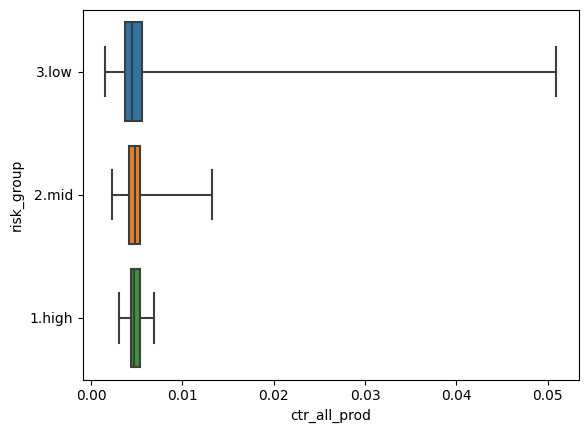

In [0]:
sns.boxplot(data= df_pd,  y="risk_group",
              x="ctr_all_prod", whis=np.inf)
plt.show()

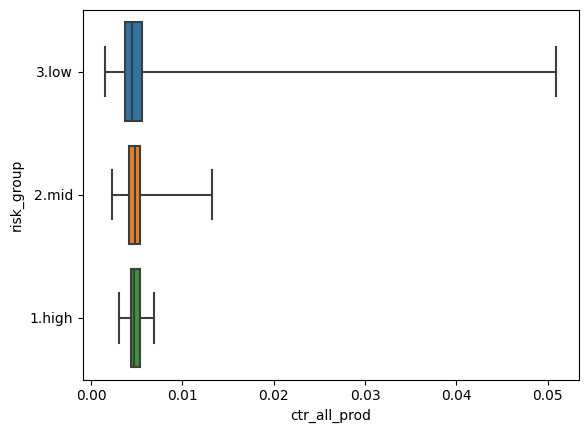

In [0]:
sns.boxplot(data= df_pd,  y="risk_group",
              x="ctr_all_prod", whis=np.inf)
plt.show()

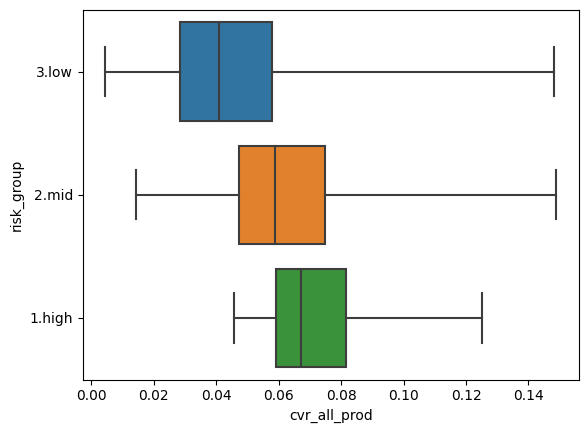

In [0]:
sns.boxplot(data= df_pd,  y="risk_group",
              x="cvr_all_prod", whis=np.inf)
plt.show()

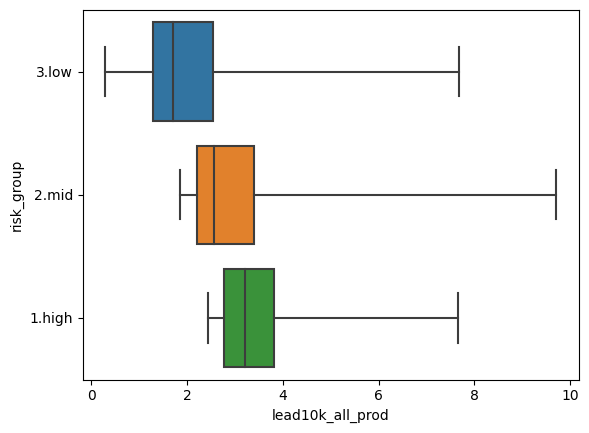

In [0]:
sns.boxplot(data= df_pd,  y="risk_group",
              x="lead10k_all_prod", whis=np.inf)
plt.show()

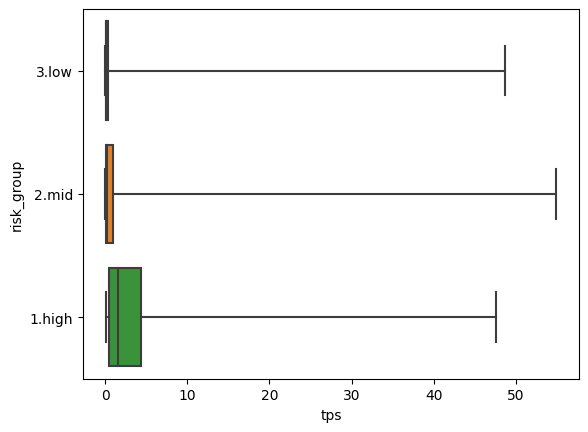

In [0]:
sns.boxplot(data= df_pd,  y="risk_group",
              x="tps", whis=np.inf)
plt.show()

/databricks/python/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 54.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/databricks/python/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 47.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/databricks/python/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/databricks/python/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 63.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/databricks/python/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarn

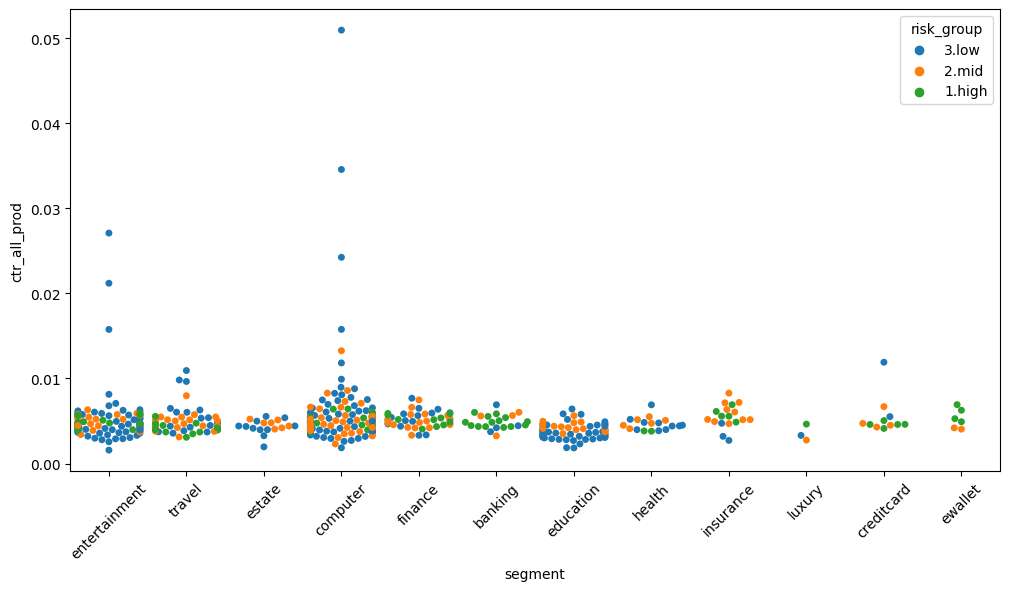

In [0]:
plt.figure(figsize=(12, 6)) 
sns.swarmplot(data= df_pd,  x="segment",
              y="ctr_all_prod", hue="risk_group")
plt.xticks(rotation=45)
plt.show()

/databricks/python/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 7.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


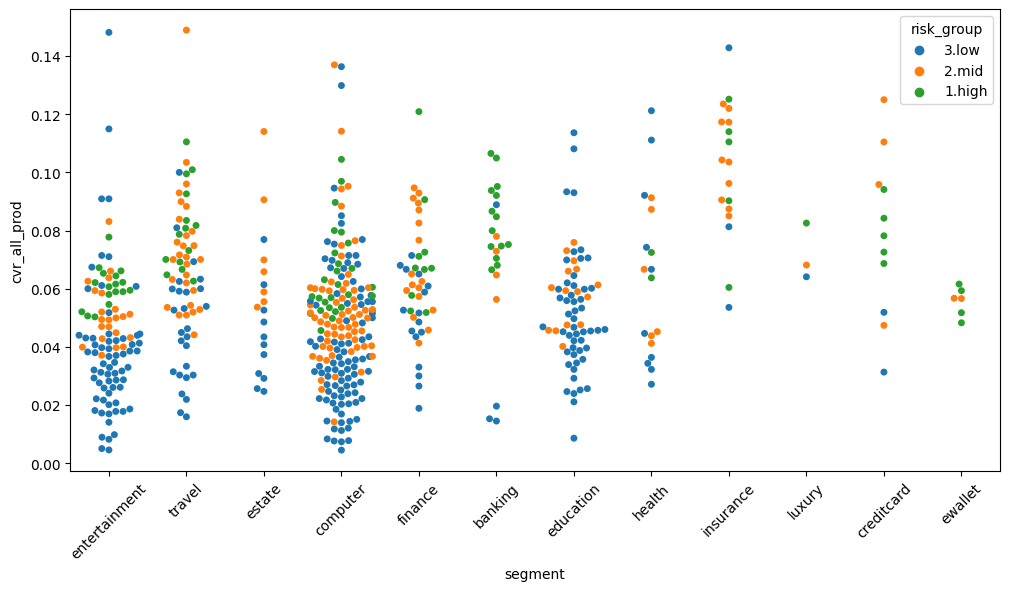

In [0]:
plt.figure(figsize=(12, 6)) 
sns.swarmplot(data= df_pd,  x="segment",
              y="cvr_all_prod", hue="risk_group")
plt.xticks(rotation=45)
plt.show()

/databricks/python/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 7.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/databricks/python/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 23.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/databricks/python/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 22.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


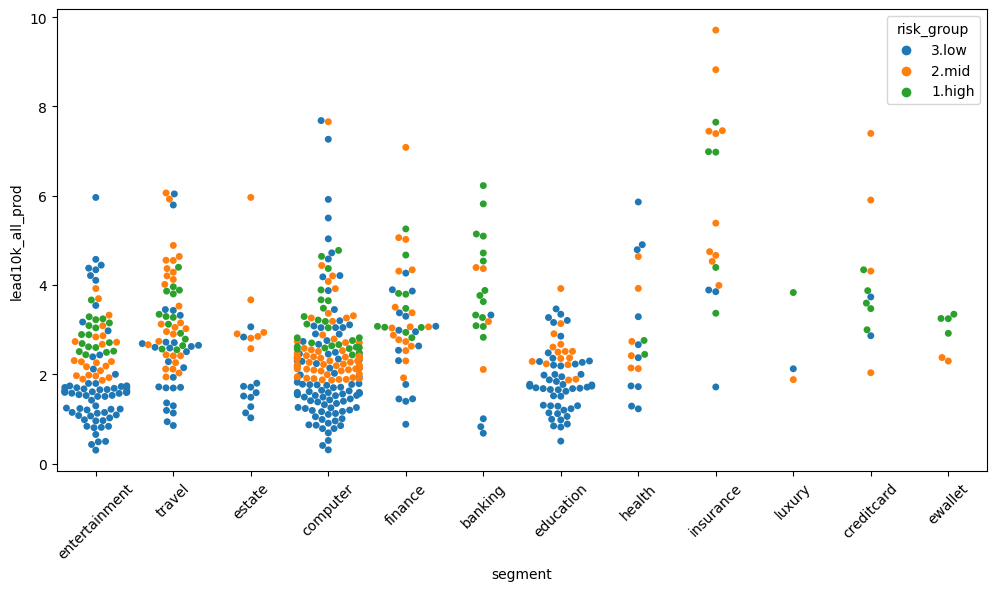

In [0]:
plt.figure(figsize=(12, 6)) 
sns.swarmplot(data= df_pd,  x="segment",
              y="lead10k_all_prod", hue="risk_group")
plt.xticks(rotation=45)
plt.show()

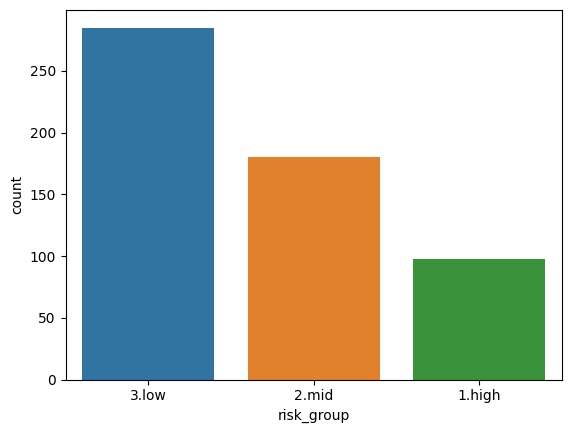

In [0]:
sns.countplot(data=df_pd,
             x="risk_group")
plt.show()

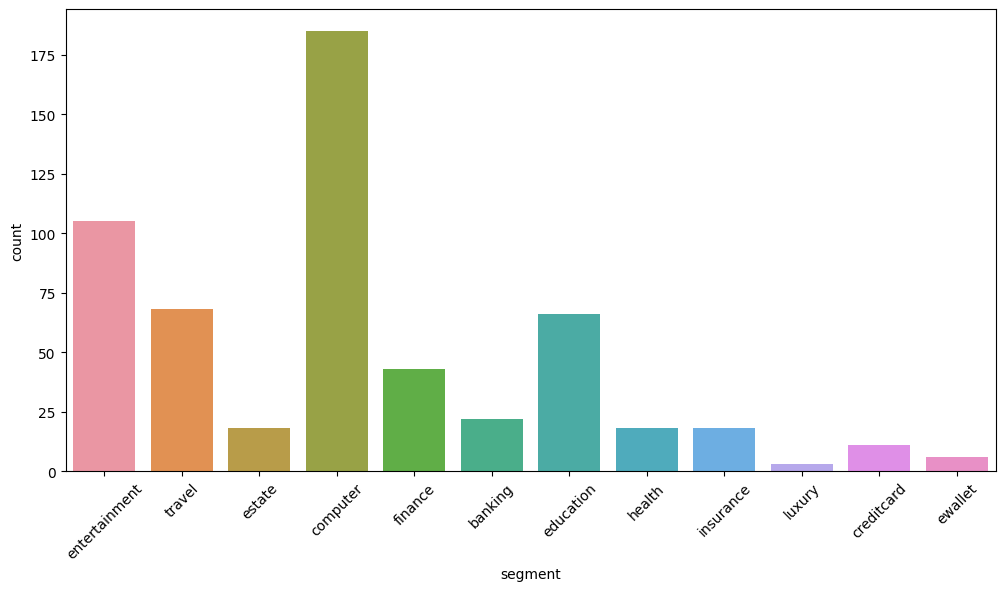

In [0]:
plt.figure(figsize=(12, 6)) 
sns.countplot(data=df_pd,
             x="segment")
plt.xticks(rotation=45)
plt.show()